In [127]:
import numpy as np 
import time 
import scipy.optimize as opt
from matplotlib import pyplot as plt

In [91]:
# parameters for the model
beta = 0.96 ** 20
delta = 1 - (1 - 0.05) ** 20
sigma = 3
A = 1
alpha = 0.35

nvec = np.array([1, 1, 0.2])
L = np.sum(nvec)
SS_tol = 1e-15

In [149]:
def get_L(n1, n2, n3):
    L = n1 + n2 + n3
    return L

def get_K(b2, b3):
    K = b2 + b3
    return K

def get_r(K, L, params):
    alpha, A, delta = params
    r = alpha * A * (L / K) ** (1 - alpha) - delta
    return r
    
def get_w(K, L, params):
    alpha, A = params
    w = (1 - alpha) * A * (K / L) ** alpha
    return w

## Exercise 2.1

In [41]:
def feasible(f_params, bvec_guess):
    '''
    input
        f_params: (nvec, A, alpha, delta)
        bvec_guess: guess for steady-state savings vector in the form np.array([scalar, scalar])
    '''
    nvec, A, alpha, delta = f_params
    b2, b3 = bvec_guess
    n1, n2, n3 = nvec
    
    b_cnstr = np.full((2), False, dtype=bool)
    c_cnstr = np.full((3), False, dtype=bool)
    K_cnstr = np.full((1), False, dtype=bool)
    
    K = b2 + b3
    K_cnstr = K < 0
    L = np.sum(nvec)
    
    r_params = (alpha, A, delta)
    r = get_r(K, L, r_params)
    w_params = (alpha, A)
    w = get_w(K, L, w_params)
    
    # HH age-specific budget constraint
    c_cnstr[0] = n1 * w - b2 < 0
    c_cnstr[1] = n2 * w + (1 + r) * b2 - b3 < 0
    c_cnstr[2] = n3 * w + (1 + r) * b3 < 0
    
    if c_cnstr[0]:
        b_cnstr[0] = True
    if c_cnstr[1]:
        b_cnstr[1] = b_cnstr[2] = True
    if c_cnstr[2]:
        b_cnstr[2] = True
    
    return b_cnstr, c_cnstr, K_cnstr

#### Part a

In [42]:
f_params = np.array([nvec, A, alpha, delta])
bvec_guess = np.array([1.0, 1.2])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print("b constraint: ", b_cnstr)
print("c constraint: ", c_cnstr)
print("K constraint: ", K_cnstr)

b constraint:  [ True False]
c constraint:  [ True False False]
K constraint:  False


#### Part b

In [43]:
bvec_guess = np.array([0.06, -0.001])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print("b constraint: ", b_cnstr)
print("c constraint: ", c_cnstr)
print("K constraint: ", K_cnstr)

b constraint:  [False False]
c constraint:  [False False False]
K constraint:  False


#### Part c

In [44]:
bvec_guess = np.array([0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print("b constraint: ", b_cnstr)
print("c constraint: ", c_cnstr)
print("K constraint: ", K_cnstr)

b constraint:  [False False]
c constraint:  [False False False]
K constraint:  False


## Exercise 2.2

In [ ]:
def get_ss():
    

In [150]:
def get_ss_endog_var(bvec, params):
    beta, sigma = params
    n1, n2, n3 = nvec
    b2, b3 = bvec
    
    K_bar = np.sum(bvec)
    L_bar = np.sum(nvec)
    
    r_params = (alpha, A, delta)
    r_bar = get_r(K_bar, L_bar, r_params)
    w_params = (alpha, A)
    w_bar = get_w(K_bar, L_bar, w_params)
    
    c_0 = n1 * w_bar - b2 
    c_1 = n2 * w_bar + (1 + r_bar) * b2 - b3 
    c_2 = n3 * w_bar + (1 + r_bar) * b3
    c_barvec = np.array([c_0, c_1, c_2])
    
    return np.array([c_barvec, w_bar, r_bar, K_bar])

In [146]:
def EE_errors(bvec_guess, args):
    
    beta, sigma = args   
    c_barvec, w_bar, r_bar, K_bar = get_endog_var(bvec_guess, args)
    c_0, c_1, c_2 = c_barvec
        
    u_prime = lambda c: c ** (-sigma)  # CRRA utility function
    
    EE1 = u_prime(c_0) - beta * (1 + r_bar) * u_prime(c_1)
    EE2 = u_prime(c_1) - beta * (1 + r_bar) * u_prime(c_2)
    
    return np.array([EE1, EE2])

In [147]:
def get_ss(params, bvec_guess, SS_graph=True):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
        
    start_time = time.clock()

    params_init = bvec_guess
    args = np.array([beta, sigma])
    b_ss = opt.fsolve(EE_errors, bvec_guess, args=args)
    K_ss = np.sum(b_ss)
    
    EulErr_ss = EE_errors(b_ss, args)
    
    ss_time = time.clock() - start_time
    
    params = np.array([beta, sigma])
    c_ss, w_ss, r_ss, K_ss = get_endog_var(b_ss, params)
    
    C_ss = np.sum(c_ss)
    Y_ss = A * (K_ss ** alpha) * (L ** (1-alpha)) 
    
    ss_output = {
        'b_ss': b_ss,
        'c_ss': c_ss,
        'w_ss': w_ss,
        'r_ss': r_ss,
        'K_ss': K_ss,
        'Y_ss': Y_ss,
        'C_ss': C_ss,
        'EulErr_ss': EulErr_ss,
        'RCerr_ss': Y_ss - C_ss - delta * K_ss,
        'ss_time': ss_time        
    }
    
    if SS_graph:
        fig, ax = plt.subplots(figsize=(6,6))
        s = np.array([1, 2, 3])
        plt.plot(s, c_ss, label=r'$c_{ss}$', marker='.')
        plt.plot(s[1:], b_ss, label=r'$b_{ss}$', marker='.')
        plt.title("Steady-State Consumption and Savings")
        plt.legend()
        plt.grid()
        plt.xlabel("Age (s)")
        plt.ylabel("Level")
        plt.xticks(s)
        plt.show()
    
    return ss_output

#### Part a and b

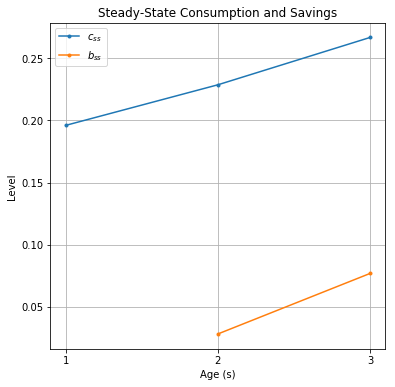

{'b_ss': array([0.02817696, 0.07686557]),
 'c_ss': array([0.19597535, 0.22861559, 0.26669216]),
 'w_ss': 0.22415231191003757,
 'r_ss': 1.8863599991451423,
 'K_ss': 0.1050425255076521,
 'Y_ss': 0.7586693633878195,
 'C_ss': 0.691283104528901,
 'EulErr_ss': array([6.93489710e-12, 2.54374299e-12]),
 'RCerr_ss': -5.551115123125783e-17,
 'ss_time': 0.0010329999999996176}

In [148]:
params = ((beta, sigma, nvec, L, A, alpha, delta, SS_tol))
bvec_guess = (0.1, 0.1)
get_ss(params, bvec_guess,)

#### Part c

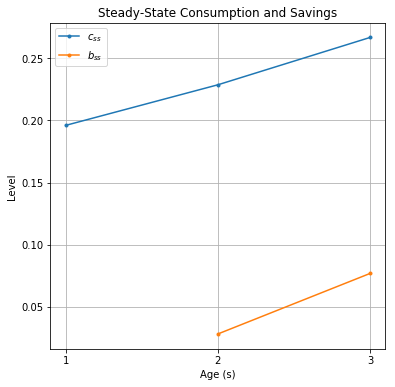

{'b_ss': array([0.02817696, 0.07686557]),
 'c_ss': array([0.19597535, 0.22861559, 0.26669216]),
 'w_ss': 0.22415231191003757,
 'r_ss': 1.8863599991451423,
 'K_ss': 0.1050425255076521,
 'Y_ss': 0.7586693633878195,
 'C_ss': 0.691283104528901,
 'EulErr_ss': array([6.93489710e-12, 2.54374299e-12]),
 'RCerr_ss': -5.551115123125783e-17,
 'ss_time': 0.0006930000000000547}

In [135]:
beta = 0.55
params = ((beta, sigma, nvec, L, A, alpha, delta, SS_tol))
bvec_guess = (0.1, 0.1)
get_ss(params, bvec_guess)

## Exercise 2.3

In [ ]:
def get_c_vec(r_vec, w_vec, nvec, bvec):
    
    c_0 = w_vec[0] * nvec[0] - bvec[1] 
    c_1 = w_vec[1] * nvec[1] + (1 + rvec[1]) * bvec[2] - bvec[3]
    c_3 = w_vec[2] * nvec[2] + (1 + rvec[2]) * bvec[3]
    
    return np.array([c_0, c_1, c_2])

In [ ]:
def EE_errors(bvec_guess, args):
    
    beta, sigma = args   
    c_barvec, w_bar, r_bar, K_bar = get_endog_var(bvec_guess, args)
    c_0, c_1, c_2 = c_barvec
        
    u_prime = lambda c: c ** (-sigma)  # CRRA utility function
    
    c_0 = 
    
    EE1 = u_prime(c_0) - beta * (1 + r_bar) * u_prime(c_1)
    EE2 = u_prime(c_1) - beta * (1 + r_bar) * u_prime(c_2)
    EE3 = 
    
    return np.array([EE1, EE2])

In [ ]:
def get_TPI(params, bvec_guess, bvec_init, T, TPI_graph=True):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    
    output = get_ss(params, bvec_guess)
    K_bar = output[K_ss]
    r_bar = output[r_ss]
    w_bar = output[w_ss]
    bvec_bar = output[b_ss]
    
    K_guess = np.ones(3)
    K_guess[0] = np.sum(bvec_init)
    K_guess[2] = np.sum(bvec_bar)
    
    r_vec = alpha * A * (L / K_guess) ** (1 - alpha) - delta
    w_vec = (1 - alpha) * A * (K_guess / L) ** alpha
    
    
    
    
    
    

#### HH Problem 

In [ ]:
def marg_ut_cons(c, sigma):
    '''
    Assume CRRA Utility function. 
    '''
    return c ** (-sigma)

In [159]:
def firstdoughnutring(b32_guess, args):
    '''
    Solves the first entries (b32) of the upper triangle of the tiwst
    doghnut. This is separate from the main TPI function. 
    
    Params:
        bvec_init: initial capital distribution (b21, b31)
        
    Returns:
        EE: Euler error for the FOC for saving 
        (Middle Age Agent Problem).
    '''
    r_path, w_path, nvec, bvec_init = args
    b21, b31 = bvec_init
    
    c_21 = w_path[0] * nvec[1] + (1 + rpath[0]) * b21 - b32
    c_32 = w_path[1] * nvec[2] - (1 + rpath[1]) * b32
    
    EE = marg_ut_cons(c_21, sigma) - beta * (1 + r_vec[2]) \
            * marg_ut_cons(c_32, sigma)
    
    return EE

In [152]:
def get_c_vec(r_vec, w_vec, nvec, bvec):
    '''
    '''
    
    c_1 = w_vec[0] * nvec[0] - bvec[1] 
    c_2 = w_vec[1] * nvec[1] + (1 + rvec[1]) * bvec[2] - bvec[3]
    c_3 = w_vec[2] * nvec[2] + (1 + rvec[2]) * bvec[3]
    
    return np.array([c_1, c_2, c_3])    

In [ ]:
def twist_doughnut():
    '''
    Returns:
        EE: Euler errors for the FOC for savig 
        (Young Age Agent Problem)
    '''
    
    c1 = nvec[0] * wpath[0] - bvec[0]
    c2 = nvec[1] * wpath[1] + (1 + rpath[0]) * bvec[0] - bvec[1]
    c3 = (1 + rpath[1]) * bvec[1] + nvec[2] * wpath[2]
    

        c1 = nvec[0] * wpath[0] - bvec[0]
    c2 = nvec[1] * wpath[1] + (1 + rpath[0]) * bvec[0] - bvec[1]
    c3 = (1 + rpath[1]) * bvec[1] + nvec[2] * wpath[2]
    

In [ ]:
def get_c_vec(r_vec, w_vec, nvec, bvec):
    
    c_1 = w_vec[0] * nvec[0] - bvec[1] 
    c_2 = w_vec[1] * nvec[1] + (1 + rvec[1]) * bvec[2] - bvec[3]
    c_3 = w_vec[2] * nvec[2] + (1 + rvec[2]) * bvec[3]
    
    return np.array([c_1, c_2, c_3])    

In [ ]:
c1 = nvec[0] * wpath[0] - bvec[0]
    c2 = nvec[1] * wpath[1] + (1 + rpath[0]) * bvec[0] - bvec[1]
    c3 = (1 + rpath[1]) * bvec[1] + nvec[2] * wpath[2]
    

In [ ]:
def EE_solve_b2t_b3t1(bvec)

In [154]:
def FOC_savings(rvec, wvec, nvec, bvec, beta, sigma, method):
    '''
    Computes Euler errors for the FOC for savings in SS.
    '''
    c_0, c_1, c_2 = get_c_vec(r_vec, w_vec, nvec, bvec)
    
    if method == "firstdougnutring":
        EE1 = marg_ut_cons(c_0, sigma) - beta * (1 + r_vec[1]) * marg_ut_cons(c_1, sigma)
        EE2 = marg_ut_cons(c_1, sigma) - beta * (1 + r_bar[2]) * marg_ut_cons(c_2, sigma)
        EE = np.array([EE1, EE2])
    
    if method == "twist_doghnnut":
        EE = marg_ut_cons(c_1, sigma) - beta * (1 + r_vec[2]) * marg_ut_cons(c_2, sigma)
        
    else:
        raise ValueError("Not an option for method!")
        
    return EE

#### TPI Method

In [155]:
def firstdoughnutring(rvec, wvec, nvec, initial_bvec, beta, sigma, method):
    '''
    Solves the first entries of the upper triangle of the tiwst
    doghnut. This is separate from the main TPI function. 
    '''
    EE = FOC_savings(rvec, wvec, nvec, initial_bvec, beta, sigma, method = "firstdougnutring")
    
    return EE

In [ ]:
def twist_doughnut():
    EE1, EE2 = FOC_savings(rvec, wvec, nvec, bvec, beta, sigma, method)

In [ ]:
def firstdoughnutring(guesses, r, w, nvec, initial_b):
    
    c_0, c_1, c_2 = get_c_vec(r_vec, w_vec, nvec, bvec)
    
    
    

In [ ]:
def twist_doghnnut()

In [ ]:
def get_ss_endog_var(bvec, params):
    beta, sigma = params
    n1, n2, n3 = nvec
    b2, b3 = bvec
    
    K_bar = np.sum(bvec)
    L_bar = np.sum(nvec)
    
    r_params = (alpha, A, delta)
    r_bar = get_r(K_bar, L_bar, r_params)
    w_params = (alpha, A)
    w_bar = get_w(K_bar, L_bar, w_params)
    
    c_0 = n1 * w_bar - b2 
    c_1 = n2 * w_bar + (1 + r_bar) * b2 - b3 
    c_2 = n3 * w_bar + (1 + r_bar) * b3
    c_barvec = np.array([c_0, c_1, c_2])
    
    return np.array([c_barvec, w_bar, r_bar, K_bar])

In [ ]:
def get_ss(params, bvec_guess, SS_graph=False):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    b2, b3 = bvec_guess
    
    K_old = b2 + b3
    
    diff = SS_tol + 1
    bvec_new = bvec_guess
    
    start_time = time.clock()
    iter_ = 1

    while diff > SS_tol:
        print('iter = ', iter_)
        params_init = bvec_guess
        args = np.array([beta, sigma])
        b2_new, b3_new = opt.fsolve(EE_errors, bvec_new, args=args)
        bvec_new = np.array([b2_new, b3_new])
        
        K_new = b2_new + b3_new
        diff = np.abs(K_new - K_old)
        K_old = K_new
        iter_ += 1
    
    ss_time = time.clock() - start_time
    
    args = np.array([beta, sigma])
    EulErr_ss = EE_errors(bvec_new, args)
        
    params = np.array([beta, sigma])
    c_ss, w_ss, r_ss, K_ss = update_endog_var(bvec_new, params)
    
    C_ss = np.sum(c_ss)
    Y_ss = A * (K_ss ** alpha) * (L ** (1-alpha)) 
    
    ss_output = {
        'b_ss': bvec_new,
        'c_ss': c_ss,
        'w_ss': w_ss,
        'r_ss': r_ss,
        'K_ss': K_old,
        'Y_ss': Y_ss,
        'C_ss': C_ss,
        'EulErr_ss': EulErr_ss,
        'RCerr_ss': Y_ss - C_ss - delta * K_old,
        'ss_time': ss_time        
    }
    
    return ss_output

In [48]:
def update_guess(params, bvec_guess):
    
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    
    b2, b3 = bvec_guess
    
    K_bar = np.sum(bvec_guess)
    L_bar = np.sum(nvec)
    
    r_params = (alpha, A, delta)
    r_bar = get_r(K_bar, L_bar, r_params)
    w_params = (alpha, A)
    w_bar = get_w(K_bar, L_bar, w_params)
    
    params_init = bvec_guess
    args = np.array([nvec, r_bar, w_bar, beta, sigma])
    b2_ss, b3_ss = opt.fsolve(EE_errors, params_init, args=gamma)
    
    return np.array([K_bar, r_bar, w_bar, b2_ss, b3_ss])

In [ ]:
params = ((beta, sigma, nvec, L, A, alpha, delta, SS_tol))
bvec_guess = (0.1, 0.1)
SS_graph = True

In [136]:
0.96 ** 20

0.4420024338794074